In [1]:
import re
import pandas as pd
import numpy as np
import time

from collections import defaultdict
from nltk.corpus import stopwords
from tqdm import tqdm
from scipy.sparse import csr_matrix, diags
from scipy.special import logsumexp
from scipy.sparse.linalg import svds

In [2]:
# Using default token pattern from sklearn
token_pattern = re.compile(r"(?u)\b\w\w+\b")
ngram_range = (1, 3)
min_freq = 10

In [3]:
df = pd.read_csv("yelp_review_sentiment_2classes.tsv", delimiter="\t")
df = df.dropna()

## train_test_split Implementation

In [4]:
def split_data(X, y, test_size=0.1):
    total_data = len(X)
    total_test = int(total_data * test_size)
    sample_idx = np.arange(total_data)
    np.random.shuffle(sample_idx)

    X_train = X.iloc[sample_idx[total_test:]]
    y_train = y.iloc[sample_idx[total_test:]]

    X_test = X.iloc[sample_idx[:total_test]]
    y_test = y.iloc[sample_idx[:total_test]]
    return (X_train, y_train), (X_test, y_test)

In [5]:
(X_train, y_train), (X_test, y_test) = split_data(df["text"], df["sentiment"])

In [6]:
X_train.shape, X_test.shape

((224981,), (24997,))

## CountVectorizer Implementation

Something weird happens with the sklearn's CountVectorizer.

The result from CountVectorizer
'beer', 'beer copyright', 'burger', 'copyright'  
6 4 5 5  

The correct result should be  
'beer', 'pizza', 'beer copyright', 'burger', 'copyright'  
6 4 4 5 5  
'pizza' is missing from the transformation.

In [7]:
en_stopwords = stopwords.words('english') + ["-PRON-", "-pron-", "PRON", "pron"]

def preprocessing(text, ngram_range):
    tokens = token_pattern.findall(text)
    tokens = list(filter(lambda x: x not in en_stopwords, tokens))
    tokens = build_ngrams(tokens, ngram_range)
    return tokens


def build_ngrams(text, ngram_range):
    vocabs = []
    join_space = " ".join
    for i in range(ngram_range[0], ngram_range[1] + 1):
        for j in range(len(text)):
            if j + i <= len(text):
                vocabs.append(join_space(text[j:j+i]))
    return vocabs


def build_vocab(doc, ngram_range, min_freq):
    vocabs = {}
    vocab_counts = defaultdict(int)
    for text in tqdm(doc):
        tokens = preprocessing(text, ngram_range)
        for word in tokens:
            vocab_counts[word] += 1

    vocab_counts = dict(filter(lambda x: x[1] >= min_freq, vocab_counts.items()))
    for idx, key in enumerate(vocab_counts.keys()):
        vocabs[key] = idx
    return vocabs, vocab_counts


def build_count_vector(doc, vocabs):
    data = []
    indices = []
    indptr = [0]
    for text in tqdm(doc):
        tokens = preprocessing(text, ngram_range)
        feature_counts = defaultdict(int)
        for word in tokens:
            if word in vocabs:
                feature_counts[vocabs[word]] += 1
        data.extend(feature_counts.values())
        indices.extend(feature_counts.keys())
        indptr.append(len(data))
    
    return csr_matrix((data, indices, indptr), shape=(len(doc), len(vocabs)), dtype=float)

In [8]:
vocabs, vocab_counts = build_vocab(X_train, ngram_range, min_freq)

100%|██████████| 224981/224981 [01:22<00:00, 2734.20it/s]


## TfIdfVectorizer Implementation

In [9]:
def build_tfidf_vector(doc, vocabs):
    term_vectors = build_count_vector(doc, vocabs)
    document_vectors = np.bincount(term_vectors.indices, minlength=term_vectors.shape[1])
    # Add smoothing for both numerator and denumerator to prevent division by 0 or having 0
    # as the result
    idf = (term_vectors.shape[0] + 1) / (document_vectors + 1)
    idf = np.log(idf)
    # The default action for csr_matrix multiplied by numpy vector is dot product, therefore
    # we need to create a diagonal matrix first to simulate element by element multiplication
    # without blowing up the memory
    diag_idf = diags(idf, offsets=0, format="csr")
    return term_vectors * diag_idf

## Normalizer Implementation

In [10]:
def normalize(X):
    new_data = []
    for x in X:
        square_sum = 0
        for i in x.data:
            square_sum += i * i
        norm = np.sqrt(square_sum)
        new_data.extend((x.data / norm).tolist())
    new_mat = csr_matrix((np.array(new_data), X.indices, X.indptr), dtype=np.float64)
    return new_mat

## Metrics Implementation

In [11]:
def safe_division(a, b):
    if b == 0:
        return 0.
    return a / b


def confusion_matrix(true, pred):
    tp = 0
    fp = 0
    tn = 0
    fn = 0
    for y, y_hat in zip(true, pred):
        if y == 1 and y_hat == 1:
            tp += 1
        elif y == 0 and y_hat == 1:
            fp += 1
        elif y == 1 and y_hat == 0:
            fn += 1
        elif y == 0 and y_hat == 0:
            tn += 1
    return tp, fp, tn, fn


def precision_micro(true, pred):
    tp, fp, tn, fn = confusion_matrix(true, pred)
    return safe_division(tp, (tp + fp))


def recall_micro(true, pred):
    tp, fp, tn, fn = confusion_matrix(true, pred)
    return safe_division(tp, (tp + fn))


def f1_micro(true, pred):
    precision = precision_micro(true, pred)
    recall = recall_micro(true, pred)
    return safe_division((2 * precision * recall), (precision + recall))


## Cross Validation Implementation

In [12]:
from joblib import delayed, Parallel
from scipy.sparse import vstack


def cross_validate(model, X, y, folds=5):
    fold_size = int(X.shape[0] / folds)
    fold_ranges = [(i, i + fold_size) for i in range(0, X.shape[0], fold_size)]
    scores = {
        "fit_time": [],
        "score_time": [],
        "test_f1_micro": [],
        "train_f1_micro": [],
        "test_precision_micro": [],
        "train_precision_micro": [],
        "test_recall_micro": [],
        "train_recall_micro": []
    }

    def _fit(start, end):
        # Need to use vstack to deal with sparse matrix
        X_train = vstack([X[0:start], X[end:]])
        y_train = np.concatenate([y[0:start], y[end:]])

        X_test = X[start:end]
        y_test = y[start:end]

        start_time = time.time()
        model.fit(X_train, y_train)
        fit_time = time.time() - start_time

        start_time = time.time()
        preds_train = model.predict(X_train)
        preds_test = model.predict(X_test)
        score_time = time.time() - start_time

        metrics = [precision_micro, recall_micro, f1_micro]
        scores = []
        for metric in metrics:
            name = metric.__name__
            scores.append({
                f"train_{name}": metric(y_train, preds_train),
                f"test_{name}": metric(y_test, preds_test)})
        return fit_time, score_time, scores

    fit_results = Parallel(n_jobs=-1)(delayed(_fit)(start, end) for start, end in fold_ranges)
    
    for res in fit_results:
        scores["fit_time"].append(res[0])
        scores["score_time"].append(res[1])
        for score in res[2]:
            for k, v in score.items():
                scores[k].append(v)

    return scores

## OneHotEncoder and Label Encoder Implementation

In [13]:
class OneHotEncoder(object):
    def __init__(self):
        self.num_class = 0
        self.idx_mapping = {}

    def fit(self, X):
        unique_classes = np.unique(X)
        for unique_class in unique_classes:
            self.idx_mapping[unique_class] = len(self.idx_mapping)
        self.num_class = unique_classes.shape[0]

    def transform(self, X):
        idx = []
        for row in X:
            idx.append(self.idx_mapping[row])
        idx = np.array(idx)
        onehot = np.zeros((X.shape[0], self.num_class), dtype=np.int64)
        onehot[np.arange(X.shape[0]), idx] = 1
        return onehot

    def fit_transform(self, X):
        if not self.idx_mapping and self.num_class == 0:
            self.fit(X)
        return self.transform(X)

In [14]:
class LabelEncoder(object):
    def __init__(self):
        self.num_class = 0
        self.idx_mapping = {}

    def fit(self, X):
        unique_classes = np.unique(X)
        for unique_class in unique_classes:
            self.idx_mapping[unique_class] = len(self.idx_mapping)
        self.num_class = unique_classes.shape[0]

    def transform(self, X):
        label = np.zeros(X.shape[0], dtype=np.int64)
        for idx, row in enumerate(X):
            label[idx] = self.idx_mapping[row]
        return label

    def fit_transform(self, X):
        if not self.idx_mapping and self.num_class == 0:
            self.fit(X)
        return self.transform(X)

## Model Implementation

### Logistic Regression with Softmax

In [15]:
def softmax(z):
    # Ensure numerical stability
    exp_scores = np.exp(z - np.max(z, axis=1, keepdims=True))
    return exp_scores / exp_scores.sum(1)[:, np.newaxis]

def crossentropy(x, y):
    m = (x * y).sum(1)
    ce = np.log(m)
    return -ce.sum()

class SoftmaxRegression(object):
    def __init__(self, w=None, b=None, lr=0.1, epochs=10):
        self.lr = lr
        self.epochs = epochs
        self.w = w
        self.b = b
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {"w": self.w, "b": self.b, "lr": self.lr, "epochs": self.epochs}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        y = np.asarray(self.label_bin.fit_transform(y))
        # Weights and biases initialization
        limit = 1./np.sqrt(X.shape[1])
        self.w = np.random.uniform(low=-limit, high=limit, size=(X.shape[1], y.shape[1]))
        self.b = np.random.uniform(low=-limit, high=limit, size=(y.shape[1]))

        for i in range(self.epochs):
            z = X.dot(self.w) + self.b
            z = softmax(z)
            loss = crossentropy(z, y)

            # Calculate gradients
            dW = (X.T.dot(z - y) / X.shape[0])
            db = z.sum(0) / X.shape[0]

            self.w = self.w - self.lr * dW
            self.b = self.b - self.lr * db

    def predict_proba(self, X):
        z = X.dot(self.w) + self.b
        z = softmax(z)
        return z
    
    def predict(self, X):
        return self.predict_proba(X).argmax(axis=1)

### Naive Bayes

In [16]:
class NaiveBayesClassification(object):
    def __init__(self):
        self.label_bin = OneHotEncoder()

    def get_params(self, deep=True):
        # suppose this estimator has parameters "alpha" and "recursive"
        return {}

    def set_params(self, **parameters):
        for parameter, value in parameters.items():
            setattr(self, parameter, value)
        return self

    def fit(self, X, y):
        _y = np.asarray(self.label_bin.fit_transform(y))
        num_class = np.unique(y).shape[0]

        # Calculate prior probability p(y)
        self.prior = np.zeros((num_class))
        for i in range(num_class):
            self.prior[i] = (y == 1).sum() / y.shape[0]
        self.log_prior = np.log(self.prior)

        # Calculate likelihood p(x|y)
        sum_words = (_y.T @ X) + 1
        total_words = sum_words.sum()
        self.log_likelihood = np.log(sum_words) - np.log(total_words)

    def predict_proba(self, X):
        llh = X @ self.log_likelihood.T
        posterior = llh + self.log_prior
        # Normalized by Z but in logarithmic form
        posterior = posterior - logsumexp(posterior, axis=1).reshape(-1, 1)
        return np.exp(posterior)

    def predict(self, X):
        preds = self.predict_proba(X)
        return preds.argmax(axis=1)

## Latent Semantic Analysis Implementation

In [17]:
def lsa(k):
    def fn(M):
        U, s, Vt = svds(M, k)
        T = M.dot(Vt.T)
        return T
    return fn

## Cross Validation Experiments

In [18]:
logistic = SoftmaxRegression(lr=0.5, epochs=500)
nb = NaiveBayesClassification()
label_enc = LabelEncoder()
label_enc.fit(y_train)

combinations = [
    (logistic, build_count_vector, None, None),
    (logistic, build_tfidf_vector, None, None),
    (logistic, build_count_vector, normalize, None),
    (logistic, build_tfidf_vector, normalize, None),
    (logistic, build_count_vector, None, lsa(300)),
    (logistic, build_tfidf_vector, None, lsa(300)),
    (nb, build_count_vector, None, None)
]

res = {}
for comb in combinations:
    model = comb[0]
    model_name = type(model).__name__
    
    featurizer = comb[1]
    featurizer_name = featurizer.__name__
    _X_train = featurizer(X_train, vocabs)
    _y_train = label_enc.transform(y_train)
    # _X_test = featurizer(X_test, vocabs)
    # _y_test = label_enc.transform(y_test)
    
    normalizer_name = "None"
    if comb[2]:
        normalizer = comb[2]
        normalizer_name = normalizer.__name__
        _X_train = normalizer(_X_train)
        # _X_test = normalizer.transform(_X_test)
        
    decomposer_name = "None"
    if comb[3]:
        decomposer = comb[3]
        decomposer = comb[3]
        decomposer_name = decomposer.__name__
        _X_train = decomposer(_X_train)
        # _X_test = decomposer(_X_test)
        
    metadata = model_name + "-" + featurizer_name + "-" + normalizer_name + "-" + decomposer_name
    
    print("Cross-validate {}".format(metadata))
    score = cross_validate(model, _X_train, _y_train, folds=5)
    res[metadata] = score
    print(metadata, score)
    print()

100%|██████████| 224981/224981 [01:19<00:00, 2823.48it/s]


Cross-validate SoftmaxRegression-build_count_vector-None-None


  0%|          | 376/224981 [00:00<01:59, 1871.79it/s]

SoftmaxRegression-build_count_vector-None-None {'fit_time': [232.131178855896, 228.6640329360962, 228.06778287887573, 224.22521495819092, 228.84534311294556, 245.65803384780884], 'score_time': [0.21337103843688965, 0.3043198585510254, 0.3620798587799072, 0.28757596015930176, 0.2936592102050781, 0.0769948959350586], 'test_f1_micro': [0.9150220780391096, 0.9160851672928969, 0.9156717747683535, 0.9150178757799836, 0.9183732461699243, 1.0], 'train_f1_micro': [0.9211723768736617, 0.9214562700516112, 0.9213813126378381, 0.9215574548907883, 0.9207352834393658, 0.9205470152653344], 'test_precision_micro': [0.918747737965979, 0.9169054441260746, 0.9172653844437503, 0.916096042685638, 0.9208507981806832, 1.0], 'train_precision_micro': [0.9241613892183409, 0.9240289605317638, 0.9234281621415941, 0.9235178861333483, 0.9225336347966242, 0.9228881784559726], 'test_recall_micro': [0.9113265122958176, 0.9152663568108688, 0.9140836928002846, 0.913942243712017, 0.915908990109549, 1.0], 'train_recall_mic

100%|██████████| 224981/224981 [01:16<00:00, 2927.56it/s]


Cross-validate SoftmaxRegression-build_tfidf_vector-None-None


  0%|          | 120/224981 [00:00<03:07, 1196.71it/s]

SoftmaxRegression-build_tfidf_vector-None-None {'fit_time': [226.2145390510559, 224.3187620639801, 223.31201004981995, 220.43329405784607, 223.497056722641, 240.0168890953064], 'score_time': [0.14808297157287598, 0.20966005325317383, 0.2555429935455322, 0.2957339286804199, 0.22802305221557617, 0.0791158676147461], 'test_f1_micro': [0.9276856249015327, 0.9295284030010719, 0.9270626989249706, 0.9289435020702551, 0.9284763510515573, 1.0], 'train_f1_micro': [0.9854313782272616, 0.9853574792791889, 0.9853753221110404, 0.9854580761804849, 0.9851451156403342, 0.9805220309933587], 'test_precision_micro': [0.9305549284327448, 0.9288646911817208, 0.9279921575617146, 0.9323472898699674, 0.9288472635270096, 1.0], 'train_precision_micro': [0.9873228434326526, 0.9870905781321541, 0.986563913553359, 0.98647093653294, 0.9865164016904809, 0.9823899258570266], 'test_recall_micro': [0.9248339615867888, 0.9301930639971397, 0.9261351002801619, 0.9255644767777137, 0.9281057346875415, 1.0], 'train_recall_mic

100%|██████████| 224981/224981 [01:17<00:00, 2890.46it/s]


Cross-validate SoftmaxRegression-build_count_vector-normalize-None


  0%|          | 167/224981 [00:00<02:15, 1655.77it/s]

SoftmaxRegression-build_count_vector-normalize-None {'fit_time': [223.52940917015076, 222.8086497783661, 221.86705994606018, 218.66800475120544, 222.27337384223938, 239.2504162788391], 'score_time': [0.20783424377441406, 0.20789504051208496, 0.2573509216308594, 0.32579493522644043, 0.30600881576538086, 0.08613133430480957], 'test_f1_micro': [0.8399891579327792, 0.8440613455725959, 0.8409095980897547, 0.8410391700947953, 0.8417700376366836, 1.0], 'train_f1_micro': [0.8424330867593695, 0.8414803375187448, 0.8421040841812878, 0.8419162279646651, 0.8417104696010433, 0.8418404572942825], 'test_precision_micro': [0.8456430780425687, 0.8457086455202117, 0.8439795735531267, 0.847825107054316, 0.8453658972982645, 1.0], 'train_precision_micro': [0.8474414209703365, 0.8462534044612511, 0.8465366600612503, 0.8449557561873962, 0.8452164137155705, 0.8459033500053974], 'test_recall_micro': [0.8344103392568659, 0.84242045048266, 0.8378618757504336, 0.8343609989797276, 0.8382046391981195, 1.0], 'train_

100%|██████████| 224981/224981 [01:21<00:00, 2746.92it/s]


Cross-validate SoftmaxRegression-build_tfidf_vector-normalize-None


  0%|          | 161/224981 [00:00<02:20, 1604.15it/s]

SoftmaxRegression-build_tfidf_vector-normalize-None {'fit_time': [243.6550772190094, 241.89380288124084, 241.6330921649933, 237.4497628211975, 241.06980109214783, 257.2757863998413], 'score_time': [0.17233896255493164, 0.21787500381469727, 0.2240748405456543, 0.27785825729370117, 0.24553704261779785, 0.08696317672729492], 'test_f1_micro': [0.8671704823294066, 0.8680892124827299, 0.8679600595603048, 0.8661424221847415, 0.8664702673213311, 1.0], 'train_f1_micro': [0.8691280319312251, 0.8683386956855942, 0.8685898844311641, 0.8688147485272883, 0.8680880035579177, 0.8682933683438643], 'test_precision_micro': [0.8591121289526997, 0.8522585367954183, 0.8549674302230275, 0.8555170921678927, 0.8528653664404159, 1.0], 'train_precision_micro': [0.8574503991864818, 0.8569988728975204, 0.8565733167217378, 0.855860338337732, 0.8551894242627491, 0.8560136445491066], 'test_recall_micro': [0.8753814395979178, 0.8845191276367537, 0.8813536710099168, 0.8770349997782017, 0.8805162549341375, 1.0], 'train_

100%|██████████| 224981/224981 [01:16<00:00, 2945.09it/s]


Cross-validate SoftmaxRegression-build_count_vector-None-fn


  0%|          | 27/224981 [00:00<14:05, 265.97it/s]

SoftmaxRegression-build_count_vector-None-fn {'fit_time': [629.2014820575714, 629.5304338932037, 629.2956352233887, 632.6180901527405, 630.3139593601227, 702.4358022212982], 'score_time': [1.144320011138916, 1.0869488716125488, 1.164362907409668, 0.7558290958404541, 1.5350902080535889, 0.3978750705718994], 'test_f1_micro': [0.8918650345544061, 0.89433480432786, 0.893821449223789, 0.892549889135255, 0.8960398239921774, 1.0], 'train_f1_micro': [0.89458130276232, 0.8940475659274463, 0.894027792510873, 0.8945784309893288, 0.8936286634766246, 0.8942793233233769], 'test_precision_micro': [0.8977448395016823, 0.8965641140803953, 0.8940600667408232, 0.8922729086314669, 0.8979555476370763, 1.0], 'train_precision_micro': [0.8974135230679733, 0.8962270480620849, 0.895973680087733, 0.8961246727675475, 0.8950429491768075, 0.8962681224270628], 'test_recall_micro': [0.8860617483396158, 0.8921165534501251, 0.8935829590430027, 0.8928270416537284, 0.8941322570630239, 1.0], 'train_recall_micro': [0.89176

100%|██████████| 224981/224981 [01:22<00:00, 2725.11it/s]


Cross-validate SoftmaxRegression-build_tfidf_vector-None-fn


  0%|          | 89/224981 [00:00<04:17, 871.89it/s]

SoftmaxRegression-build_tfidf_vector-None-fn {'fit_time': [670.0725450515747, 669.9183571338654, 670.5886681079865, 669.1399509906769, 671.4852070808411, 743.4385719299316], 'score_time': [0.9737539291381836, 1.3017199039459229, 1.071652889251709, 1.3111271858215332, 1.3402812480926514, 0.4607679843902588], 'test_f1_micro': [0.9070170307543477, 0.9089001495635869, 0.908674479108759, 0.9069190195470057, 0.9095474037371964, 1.0], 'train_f1_micro': [0.9088439615247597, 0.908656470352341, 0.9089004768908499, 0.9090017224176278, 0.9085895414714582, 0.9088016400017827], 'test_precision_micro': [0.9094518384840965, 0.9079880469202979, 0.9087351005159224, 0.9061960228530935, 0.9113089937666964, 1.0], 'train_precision_micro': [0.9101612147969764, 0.909578501338091, 0.9089308596579196, 0.9089561223579774, 0.9079471820793159, 0.9091419756939181], 'test_recall_micro': [0.904595225273739, 0.9098140865212728, 0.9086138657891226, 0.9076431708290822, 0.9077926109903757, 1.0], 'train_recall_micro': [0.

100%|██████████| 224981/224981 [01:27<00:00, 2578.70it/s]


Cross-validate NaiveBayesClassification-build_count_vector-None-None
NaiveBayesClassification-build_count_vector-None-None {'fit_time': [0.342987060546875, 0.34334325790405273, 0.3730318546295166, 0.33892297744750977, 0.34114813804626465, 0.44217920303344727], 'score_time': [0.3437027931213379, 0.3071000576019287, 0.3065989017486572, 0.3380873203277588, 0.35144710540771484, 0.27550315856933594], 'test_f1_micro': [0.8086326434864203, 0.8122739952474429, 0.8071129057307034, 0.8068691661079882, 0.8058721666537437, 0.0], 'train_f1_micro': [0.8298089171974522, 0.8284512418534288, 0.8256358296245944, 0.8262018367451645, 0.8254760880867261, 0.8246476598668053], 'test_precision_micro': [0.9645566471831861, 0.9623011015911873, 0.9655663590759893, 0.963482973089476, 0.9656838453914767, 0.0], 'train_precision_micro': [0.9715717567043523, 0.9714666387221366, 0.972607913940804, 0.9725363489499192, 0.9726970201179852, 0.9711287673879444], 'test_recall_micro': [0.6961048285765572, 0.7027171969967823,

In [19]:
analysis_df = pd.DataFrame()
for k, v in res.items():
    tmp_df = pd.DataFrame.from_dict(res[k])
    tmp_df["meta"] = k
    
    analysis_df = pd.concat([analysis_df, tmp_df])

In [20]:
analysis_df["meta"] = analysis_df["meta"].map(lambda x: x.replace("-fn", "-TruncatedSVD"))

(0.8, 0.95)

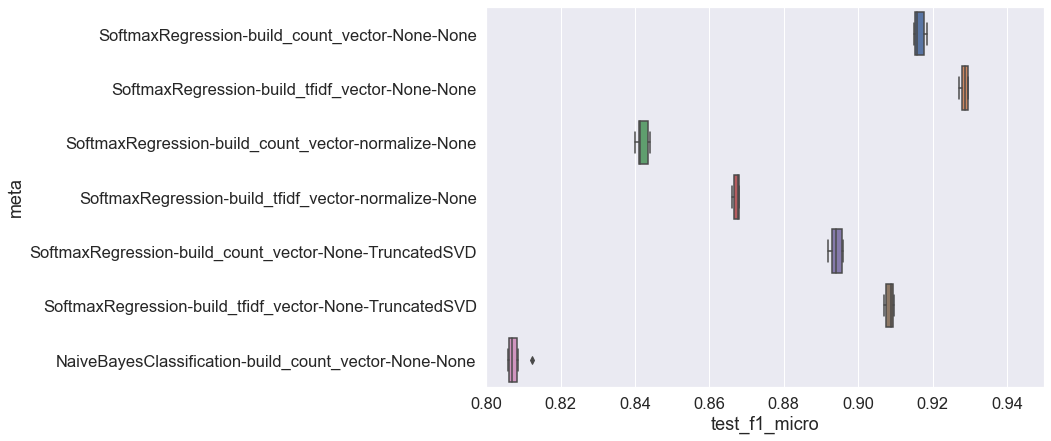

In [21]:
from matplotlib import pyplot
import seaborn as sns

sns.set(font_scale=1.5)
a4_dims = (10, 7)
fig, ax = pyplot.subplots(figsize=a4_dims)
g = sns.boxplot(data=analysis_df, x="test_f1_micro", y="meta")
g.set_xlim([0.8, 0.95])

In [22]:
analysis_df.to_csv("all_scratch_performance.csv", index=False)

## Testing Performance with Testing Data

In [23]:
label_enc = LabelEncoder()
label_enc.fit(y_train)
_X_train = build_tfidf_vector(X_train, vocabs)
_y_train = label_enc.transform(y_train)
_X_test = build_tfidf_vector(X_test, vocabs)
_y_test = label_enc.transform(y_test)
model = SoftmaxRegression(lr=0.5, epochs=500)
model.fit(_X_train, _y_train)
preds = model.predict(_X_test)

metrics = [precision_micro, recall_micro, f1_micro]
scores = []
for metric in metrics:
    name = metric.__name__
    print(f"{name}:", metric(_y_test, preds))

100%|██████████| 24997/24997 [00:08<00:00, 2905.02it/s]


precision_micro: 0.9284007645747053
recall_micro: 0.9281789951429253
f1_micro: 0.9282898666135776
